# Games Sales Price Regression:

On this project, the idea is to analyse the data from the "games.csv" dataset, and create a regression model with multiple output in order to predict the values from a specific video game on a specific cluster of countrys as will be described below.

Games database: 

The games database, brings to our project some informations about specific games described at "games.csv" files. Some of the informations are:
* The name of the video game;
* The platform (Console) used to run it;
* Critics scores;
* Sale price on "North America", "Europe" and "Japan". 

Some other informations are described on the file.

The output information we want to predict is the "Sales Price" on one of 3 clusters of country listed at the end of the list described. 

First thing we will do, is to import the libraries needed to our project:

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torch import nn, optim

torch.__version__

'1.6.0'

In [20]:
torch.manual_seed(123)

Importing the games dataset and viewing it's shape:

In [32]:
videoGames = pd.read_csv('../../Bases/games.csv')

videoGames.shape

(16719, 16)

We can have a first view about the data we will be manippulating throught it's first 5 rows:

In [26]:
videoGames.head()

,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
0,Wii Sports,Wii,2006.0,Sports,Nintendo,41.36,28.96,3.77,8.45,82.53,76.0,51.0,8,322.0,Nintendo,E
1,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24,NaN,NaN,NaN,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.68,12.76,3.79,3.29,35.52,82.0,73.0,8.3,709.0,Nintendo,E
3,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.61,10.93,3.28,2.95,32.77,80.0,73.0,8,192.0,Nintendo,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37,NaN,NaN,NaN,NaN,NaN,NaN


Viewing only the first rows and the shape of the data, can give us a general idea of what we are going analyse. But it doesn't give us any important information about each feature to be analysed. In order of that, we may see some statistical informations about the features, and it's distribution. So, we may use the **"descibe()"** method from pandas library.

In [28]:
videoGames.describe()

,Year_of_Release,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Count
count,16450.000000,16719.000000,16719.000000,16719.000000,16719.000000,16719.000000,8137.000000,8137.000000,7590.000000
mean,2006.487356,0.263330,0.145025,0.077602,0.047332,0.533543,68.967679,26.360821,162.229908
std,5.878995,0.813514,0.503283,0.308818,0.186710,1.547935,13.938165,18.980495,561.282326
min,1980.000000,0.000000,0.000000,0.000000,0.000000,0.010000,13.000000,3.000000,4.000000
25%,2003.000000,0.000000,0.000000,0.000000,0.000000,0.060000,60.000000,12.000000,10.000000
50%,2007.000000,0.080000,0.020000,0.000000,0.010000,0.170000,71.000000,21.000000,24.000000
75%,2010.000000,0.240000,0.110000,0.040000,0.030000,0.470000,79.000000,36.000000,81.000000
max,2020.000000,41.360000,28.960000,10.220000,10.570000,82.530000,98.000000,113.000000,10665.000000


# Drop features

One of the first things we may do at this project, is to drop the columns that we wont need to build our model, or may harm the accuracy of the model. Some of the columns we may drop here, are: 
* Developer: As we already have the Publisher value on our dataset, mantain the Developer, would be a redundance. So, instead of Developer, we will use the "Publisher" columnn isntead;
* Global_Sales and Other_Sales: The global sales will some all sales from our dataset, so, as we want to predict the sales of a video game from "North America", "Europe" and "Japan", we can't have the global sale as a parameter, because this will interfere on the model's prediction.

In [33]:
videoGames.drop(['Developer', 'Global_Sales', 'Other_Sales'], axis=1, inplace=True)
videoGames.shape

(16719, 13)

## Non-Numeric Features analysis:

Let's have a closer look at the "non-numeric" features. These analysis may give us some information about the classes listed here. As an example, if the gender of the video games listed on the dataset have 90% of the information labeled as "Action", we should clean these data, as the dataset is unbalanced. A possible way to do this, is to analyse the unique values on each feature, and how relevant each of them are. 

### Creating a function for plotting Pareto Chart:

In [99]:
from matplotlib.ticker import PercentFormatter

def pareto_chart(df_, Column):
    df = pd.DataFrame({Column:df_[Column].value_counts().index.astype(str).tolist(), 'Count':df_[Column].value_counts().tolist()})
    df['Percentage'] = df['Count'].cumsum()/df['Count'].sum()*100

    fig, ax = plt.subplots(figsize=(20,5))
    ax.bar(df[Column], df['Count'], color='C0')
    ax2 = ax.twinx()
    ax2.plot(df[Column], df['Percentage'], color='C1', marker=".")
    ax2.yaxis.set_major_formatter(PercentFormatter())

    ax.tick_params(axis="y", colors="C0")
    ax.tick_params(axis="y", colors="C1")

    for tick in ax.get_xticklabels():
        tick.set_rotation(45)
    plt.show()

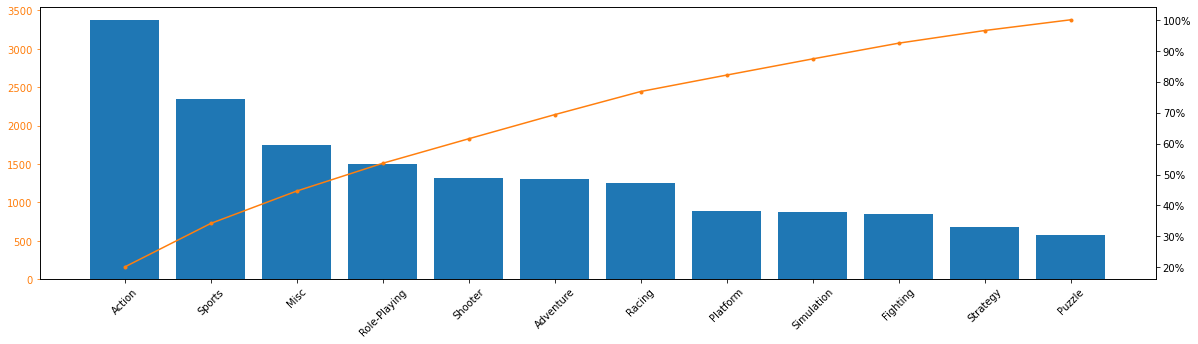

In [100]:
pareto_chart(videoGames, 'Genre')

Electronic Arts                 1356
Activision                       985
Namco Bandai Games               939
Ubisoft                          933
Konami Digital Entertainment     834
                                ... 
fonfun                             1
SPS                                1
Square EA                          1
Elite                              1
Quest                              1
Name: Publisher, Length: 581, dtype: int64


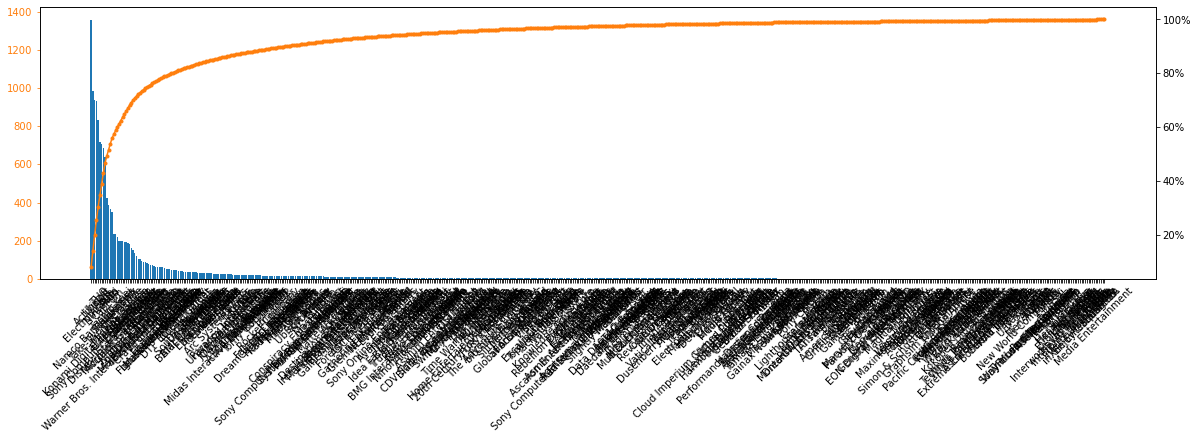

In [111]:
print(videoGames['Publisher'].value_counts())
pareto_chart(videoGames, 'Publisher')

In [122]:
videoGames['Developer'].value_counts()

KeyError: 'Developer'

In [18]:
pareto_chart(videoGames, 'Rating')

E       3991
T       2961
M       1563
E10+    1420
EC         8
RP         3
K-A        3
AO         1
Name: Rating, dtype: int64

In [86]:
pareto_chart(videoGames, 'Platform')

PS2     2161
DS      2152
PS3     1331
Wii     1320
X360    1262
PSP     1209
PS      1197
PC       974
XB       824
GBA      822
GC       556
3DS      520
PSV      432
PS4      393
N64      319
XOne     247
SNES     239
SAT      173
WiiU     147
2600     133
NES       98
GB        98
DC        52
GEN       29
NG        12
WS         6
SCD        6
3DO        3
TG16       2
PCFX       1
GG         1
Name: Platform, dtype: int64

As we may see on the cells above, there aren't any predominant class of video games on any features analized.

In [101]:
videoGames.isnull().sum()

Name                  2
Platform              0
Year_of_Release     269
Genre                 2
Publisher            54
NA_Sales              0
EU_Sales              0
JP_Sales              0
Critic_Score       8582
Critic_Count       8582
User_Score         6704
User_Count         9129
Rating             6769
dtype: int64